## This notebook reads in CSV's that contain plot-level data and estimate regression models and does propensity score matching

In [311]:
# I will also import some regression models below...

import pandas as pd
import numpy as np
import patsy
import os
import datetime
import FIA_functions as FIA

In [312]:
# for plotting models

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [313]:
# read in data

path = "in_data"
path = os.path.join(path,"FIA_plots_16Dec19.csv")
all_plots =  pd.read_csv(path, low_memory=False).drop(columns = ['Unnamed: 0']).reset_index().rename(columns={"index": "X"})

In [314]:
# these are shannon diversity indices for small and large diameter trees; some values with no trees have missing values
# fillna fills those values with 0

all_plots.loc[:,['S_H','L_H']] = all_plots.loc[:,['S_H','L_H']].fillna(0)

In [315]:
# creating binary variables for ports trading forest products, pulp mills, and biopower plants

miles = 0.621371

all_plots.loc[:,'prts_bi'] = [1 if i > 50 else 0 for i in all_plots.prts_d*miles]
all_plots.loc[:,'plp_bi'] = [1 if i > 50 else 0 for i in all_plots.plp_d*miles]
all_plots.loc[:,'biop_bi'] = [1 if i > 30 else 0 for i in all_plots.biop_d*miles]

In [316]:
# this contains all remeasured plots for panel regression

transform_vars = ["livetree_carbon",
           "deadtree_carbon",
           "soil_carbon",
           "under_carbon",
           "L_dead_volcfgrs",
           "L_live_volcfgrs",
           "L_remvcfal"]

In [317]:
# apply this function to columns we need

def yvar_trans(column):
    newcol = np.log(min([i for i in column if i > 0])/2 + column)
    return(newcol)

In [318]:
# print out transformed variables

all_plots.loc[:,transform_vars].describe()

,livetree_carbon,deadtree_carbon,soil_carbon,under_carbon,L_dead_volcfgrs,L_live_volcfgrs,L_remvcfal
count,84666.000000,84666.000000,84666.000000,84666.000000,83561.000000,83561.000000,83561.000000
mean,64.100520,1.387806,106.424063,5.700211,12.771084,135.587207,3.783707
std,53.453676,3.827826,334.452873,57.831673,30.431893,123.369449,24.089395
min,0.000000,0.000000,32.397611,1.359858,0.000000,0.000000,0.000000
25%,30.624111,0.000000,45.252572,2.980382,0.000000,56.948337,0.000000
50%,57.232726,0.030403,72.933629,3.860271,0.536021,116.539265,0.000000
75%,87.889832,1.222103,118.186201,6.058064,12.205906,186.666245,0.000000
max,5575.293092,249.228554,38638.651819,15624.390186,843.622716,10847.568399,5954.654308


In [319]:
# use function above to transform our values

for i in transform_vars:
    all_plots.loc[:,i] = yvar_trans(all_plots.loc[:,i])

In [320]:
# transform distance to natural log

distvars = [i for i in list(all_plots) if (i.endswith('_d'))|(i == 'pellet_min')]

for i in distvars:
    all_plots.loc[:,i] = np.log(all_plots.loc[:,i].astype('float32'))

In [321]:
# de-mean continous/discrete explanatory variables

xvars = ["pdsi","poparea","pellet_min","pellet_count","plp_d","prts_d",
         "biop_d","adj_sicond","L_H","S_H","road_area","cos_aspect"]

all_plots.loc[:,xvars] = all_plots.loc[:,xvars].sub(all_plots.loc[:,xvars].mean())

In [322]:
# there are two seperate samples conatined in the csv (all removal plots and all remeasured plots)
# i created a key to distinguish the samples and we will only use one sample
# we filter out only the remeasured plots and drop the removal plots

plots = all_plots.loc[all_plots.remv_key == 0,:].reset_index(drop = True)

In [323]:
# change pellet count to only count values greater than 1

plots.loc[:,'pellet_count'] = [int(i)-1 if i > 1 else 0 for i in plots.loc[:,'pellet_count']]


In [324]:
# create a removal indicator for the remeasured plots to know which plots have any removals

plots.loc[(plots.RTPA > 0)|(plots.L_remvcfal > 0),'remv_binary'] = 1

plots.loc[:,'remv_binary'] =  plots.remv_binary.fillna(0)

In [325]:
# this is formula and columns needed for PR-score with remeasured plots
# we use wood product industry variables to gain a subsample of plots within radii of pellet mills and outside

col1 = ["plot_id","invyr","treatment","plp_pr_d","biop_pr_d",
        "prpop","prts_d",'road_area','statecd']

m1 = "treatment ~ plp_pr_d + prts_d + biop_pr_d + prpop + road_area + statecd"

In [326]:
# get dataframe for PR-score matching with remeasured plots

pr = plots.loc[pd.to_numeric(plots.invyr) > 2010,col1].reset_index(drop = True)

In [327]:
# get a list of plot_id's that are treated

treated = list(set([i for y,i in zip(list(pr.loc[:,'treatment']), list(pr.loc[:,'plot_id'])) if int(y) > 0]))

# set all treatment to 1 so that we do not match treated to non treated

pr.loc[pr.plot_id.isin(treated),'treatment'] = 1

# drop duplicates so we only have one plot_id

pr = pr.drop_duplicates(subset=['plot_id']).reset_index(drop = True)


In [328]:
# change statecd to categorical so that patsy function below interprets it as such

pr.loc[:,'statecd'] = pd.Categorical(pr.statecd)

In [329]:
# use a patsy function to make dataframes from the m1 formula and the pr dataframe

y, X = patsy.dmatrices(m1, pr, return_type='dataframe')

In [330]:
# import the discrete model to use for PR-score matching

import statsmodels.discrete.discrete_model as ds

In [331]:
# estimate and fit the models

prmod = ds.Probit(endog = y, exog = X)
matchmod = prmod.fit()

# get the propensity scoroes

prscores = pd.Series(matchmod.predict()).rename('prscore')

Optimization terminated successfully.
         Current function value: 0.475481
         Iterations 7


In [332]:
# merge the new prscores into the original dataframe

plts_pr = pr.merge(prscores, left_index = True, right_index = True).reset_index(drop = True)

In [333]:
# format the sizes of legend and figure
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          'figure.figsize': (20,10)}
plt.rcParams.update(params)

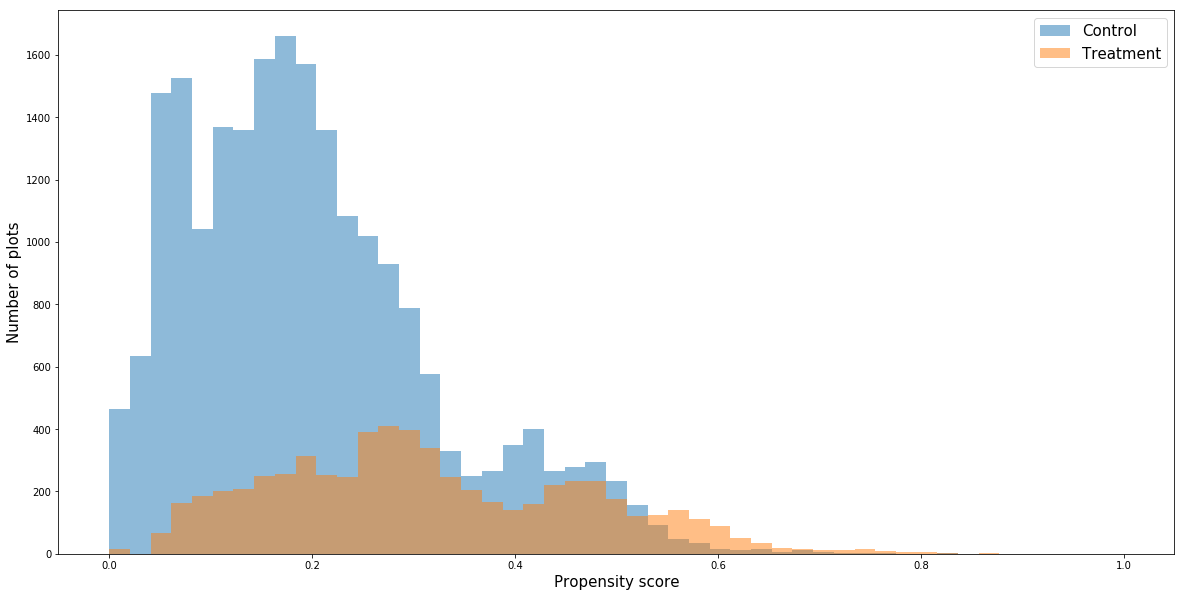

In [334]:
# plot the distribution of treated and non-treated plots after propensity score matching

# get two dataframes of treated and non-treated prscores
treat = plts_pr.loc[plts_pr['treatment'] > 0][['prscore']]
cont = plts_pr.loc[plts_pr['treatment'] == 0][['prscore']]
bins = np.linspace(0, 1, 50)

# plot values in a histogram
plt.hist(cont.prscore, bins, alpha=0.5, label='Control')
plt.hist(treat.prscore, bins, alpha=0.5, label='Treatment')
plt.legend(loc='upper right')
plt.ylabel('Number of plots', fontsize = 15)
plt.xlabel('Propensity score', fontsize = 15)


# display
plt.show()

In [335]:
# see the matchit function in FIA_functions.py
# this function is designed to match each plot 1:1 based on a propensity score
# calculated from a logit/probit regression
# must input a pandas dataframe with a column name that indicates treatment and a column that contains prscores
# this takes a long time because we have to evaluate each record and find the closest
# resampling can be set to true

matched_df = FIA.matchit(plts_pr,'treatment','prscore')

In [336]:
# get all plot_id's from matched_df

keeperlist = list(matched_df.plot_id)

# get all observations of matched plots

m_plots = plots.loc[plots.plot_id.isin(keeperlist),]

In [337]:
# delete extra stuff

del plts_pr
del keeperlist
del matched_df
del pr
del y
del X

In [338]:
# formula...

p_form = """adj_sicond + pdsi + pellet_min + pellet_min:pellet_50 + 
plp_d + poparea + prts_d + biop_d + L_H + S_H + cos_aspect + fire_wth + ins_dis + 
private + art_regen + private:art_regen"""


## Binary choice models (removals, fire-weather, artificial regeneration)
### Below is just standard logistic regressions with fixed effect intercepts

In [339]:
test = plots.loc[plots.remv_binary == 1,['invyr','plot_id','remv_binary']]

test2 = plots.sort_values(['plot_id','invyr']).loc[plots.plot_id.isin(list(test.plot_id)),['invyr','plot_id','remv_binary']]

first = test2.drop_duplicates(subset = 'plot_id',keep = 'first').fillna(0).remv_binary.sum()

second = sum(test2.remv_binary.fillna(0))

val = second - first

print('there are {} removal plots that have a previous measurement we could use for model estimation and {} total removal plots'.format(int(val),int(second)))

del test
del test2
del first
del second

there are 4358 removal plots that have a previous measurement we could use for model estimation and 9670 total removal plots


In [341]:
id_list = list(plots.loc[plots.remv_binary == 1,'plot_id'])    

In [342]:
newdf = plots.loc[plots.plot_id.isin(id_list),:]

In [343]:
allobs = len(newdf)

removalobs = int(sum(newdf.remv_binary.fillna(0)))

totalplots = len(newdf.plot_id.unique())

print("We have a total of {} plot observations, {} have a recorded removal and {} unique plot id's".format(allobs,removalobs,totalplots))

del allobs
del removalobs
del totalplots

We have a total of 23178 plot observations, 9670 have a recorded removal and 8636 unique plot id's


## Getting lagged values which takes a long time

In [344]:
ids = list(plots.plot_id.unique())

firstobs = []
dropit = []
index_dict = {}


for idx,i in enumerate(sorted(ids)):

    temp = plots.loc[plots.plot_id == i].sort_values(['invyr'])
    
    remv = sum(temp.remv_binary)
    
    if remv > 0:
        
        # just use this for a test below to make sure first obs is not removal
        
        minyear = min(list(pd.to_numeric(temp.invyr)))
        remvyear = min(list(pd.to_numeric(temp.loc[temp.remv_binary == 1,'invyr'])))
        
        # we plan to drop the whole plot if the first obs has a removal
        
        if minyear == remvyear:
            dropit.append(i)
            continue
        
    # we sort the df by inventory year and index so that the first value of
    # each iteration is the first obs in the plot which will eventually be dropped
    # I save this value to a list to create a binary later on

    for jdx,j in enumerate(temp.sort_values('invyr').index):
        if jdx == 0:
            # if it is the first one
            # save the index

            saveit = j
            
        else:

            # get the values from temp that we want

            t,v,r,rv,rb = list(temp.loc[saveit,['TPA','L_live_volcfgrs','RTPA','L_remvcfal','remv_binary']])

            # add them to a dictionary and save them with current index

            index_dict[j] = {'TPA':t,'L_live_volcfgrs':v,'RTPA':r,'L_remvcfal':rv,'remv_binary':rb}

            # save the current key

            saveit = j

In [345]:
lagged_vals = pd.DataFrame.from_dict(index_dict,orient='index').fillna(0)

In [346]:
# this inner join will drop all first observations of plots

plots_lag = plots.merge(lagged_vals,
                    how = 'inner',
                    left_index = True,
                    right_index = True,
                    indicator = True,
                    suffixes=('','_lag'))

## Import logistic model from statsmodels

In [347]:
from statsmodels.discrete.discrete_model import Logit

## Removal Model

In [348]:
remv_form = """~ remv_binary_lag + L_live_volcfgrs_lag + pdsi + mjr_access + pellet_min + pellet_50
 + pellet_count + plp_d + poparea + biop_d + L_H + S_H + fire_wth + ins_dis + stat_fed + prts_d
 + C(ecosubs) + C(statecd) + art_regen"""

f1 = 'remv_binary ' + remv_form

In [349]:
plots_lag_model = plots_lag.loc[(plots_lag.invyr <= 2014),:]

In [350]:
y, X = patsy.dmatrices(f1, plots_lag_model, return_type='dataframe')

In [351]:
remv_out_mod = Logit(y,X)

In [352]:
remv_out = remv_out_mod.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.31930407918645975
            Iterations: 209
            Function evaluations: 210
            Gradient evaluations: 209


In [353]:
print(remv_out.summary())

                           Logit Regression Results                           
Dep. Variable:            remv_binary   No. Observations:                24778
Model:                          Logit   Df Residuals:                    24744
Method:                           MLE   Df Model:                           33
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:                  0.1422
Time:                        16:41:47   Log-Likelihood:                -7911.7
converged:                       True   LL-Null:                       -9223.6
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.3289      0.158    -27.477      0.000      -4.638      -4.020
C(ecosubs)[T.M223]      0.0352      0.230      0.153      0.879      -0.416       0.486
C(ecosubs)[T.M23

In [354]:
plots_lag_predict = plots_lag.loc[(plots_lag.invyr > 2014)&(plots_lag.remv_binary!=1),:]

y_predict,X_predict = patsy.dmatrices(f1, plots_lag_predict, return_type='dataframe')

In [355]:
# these are all the columns that are in X_predict and not in X

match = [i for i in list(X_predict) if i not in list(X)]

if len(match) > 0:
    for col in match:
        del X_predict[col]

# these are all the columns in X not in X_predict

miss = [i for i in list(X) if i not in list(X_predict)]

if len(miss) > 0:
    for col in match:
        X_predict[col] = 0
        
del match
del miss

In [356]:
predicted = remv_out.predict(X_predict)
predicted = predicted.rename('predict')

In [357]:
predicted_final = plots_lag_predict.merge(predicted, left_index = True, right_index = True)

del predicted
del X_predict
del y_predict
del X
del y

In [358]:
import cartopy.crs as ccrs # these give us projectsions
import cartopy
import cartopy.geodesic as cgeo

In [363]:
def heat_scatter_map(df,lon,lat,color):
    
    plt.rcParams['figure.figsize'] = 20, 20
    
    lats = [df[lat].min()-4,df[lat].max()+4]
    lons = [df[lon].min()-4,df[lon].max()+4]
    latavg = np.mean(lats)
    lonavg = np.mean(lons)
    
    x = df[lon]
    y = df[lat]
    z = df[color]
    
    plt.axes(projection=ccrs.Mercator())
    ax = plt.axes(projection=ccrs.Mercator(lonavg))
    ax.set_extent(lons+lats)
    
    purp = sns.cubehelix_palette(as_cmap=True)
    
    ax.scatter(x, y,c=z, cmap = purp,s = 5, transform=ccrs.Geodetic())

        
    states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.OCEAN)
    
    #################### scale bar #######################
    
    project = ccrs.Mercator()
    r
    return(ax)

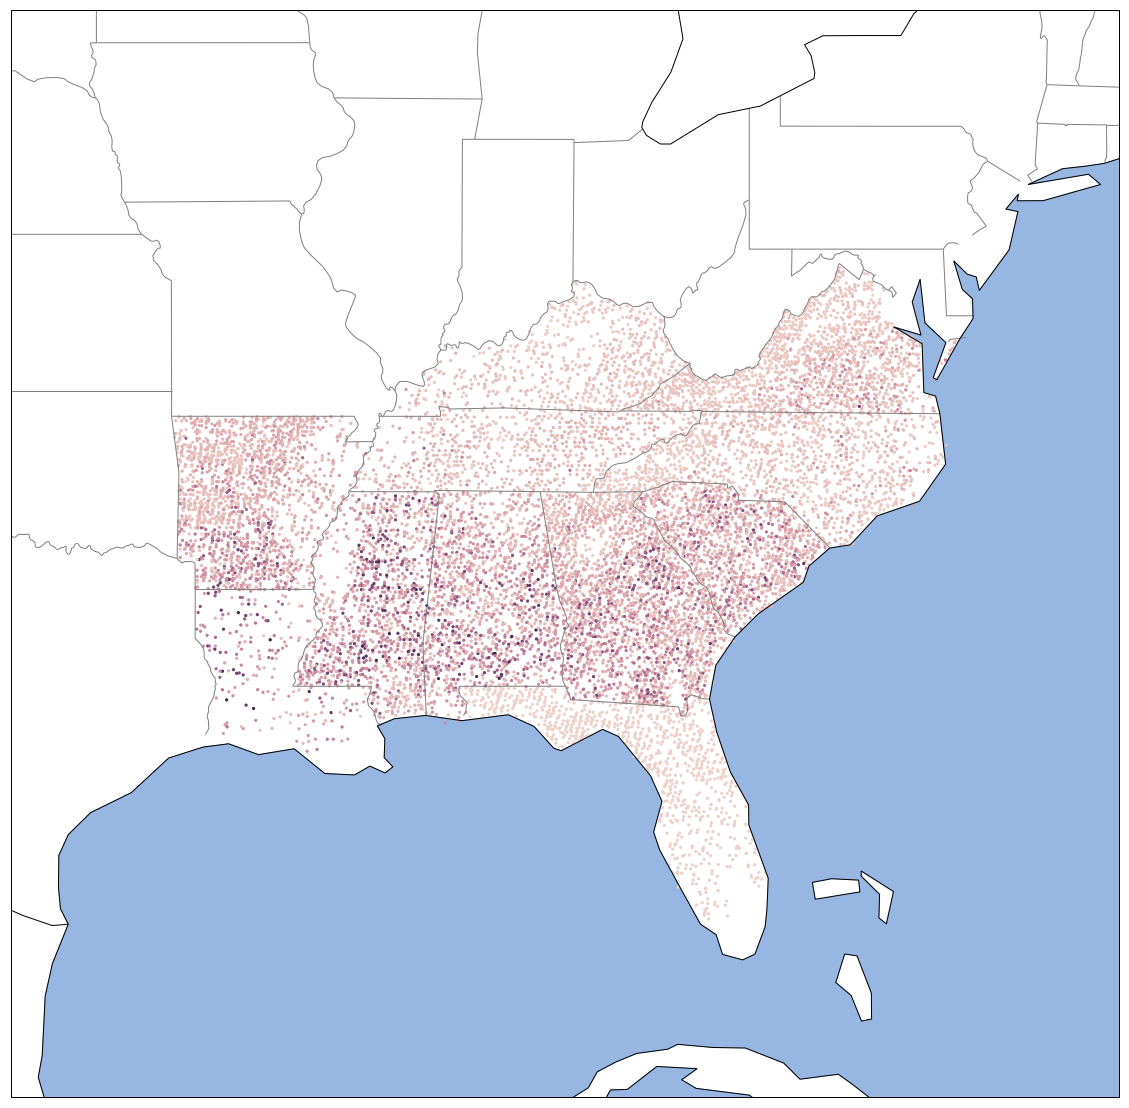

In [364]:
removal_map = heat_scatter_map(df = predicted_final,
                               lon = 'lon',
                               lat = 'lat',
                               color = 'predict')

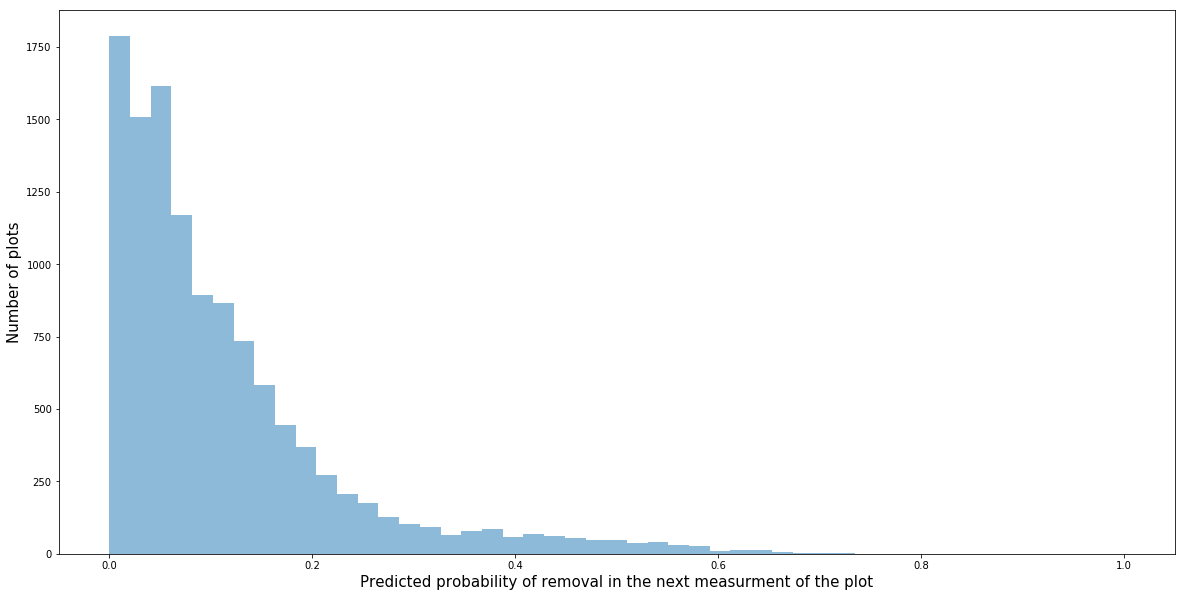

In [374]:
# reset figure size
plt.rcParams['figure.figsize'] = 20,10

# plot values in a histogram
bins = np.linspace(0, 1, 50)
plt.hist(predicted_final.predict, bins, alpha=0.5)
plt.ylabel('Number of plots', fontsize = 15)
plt.xlabel('Predicted probability of removal in the next measurment of the plot', fontsize = 15)
plt.show()


In [369]:
predicted_final['predict_bin'] = [1 if i > .5 else 0 for i in predicted_final.predict]


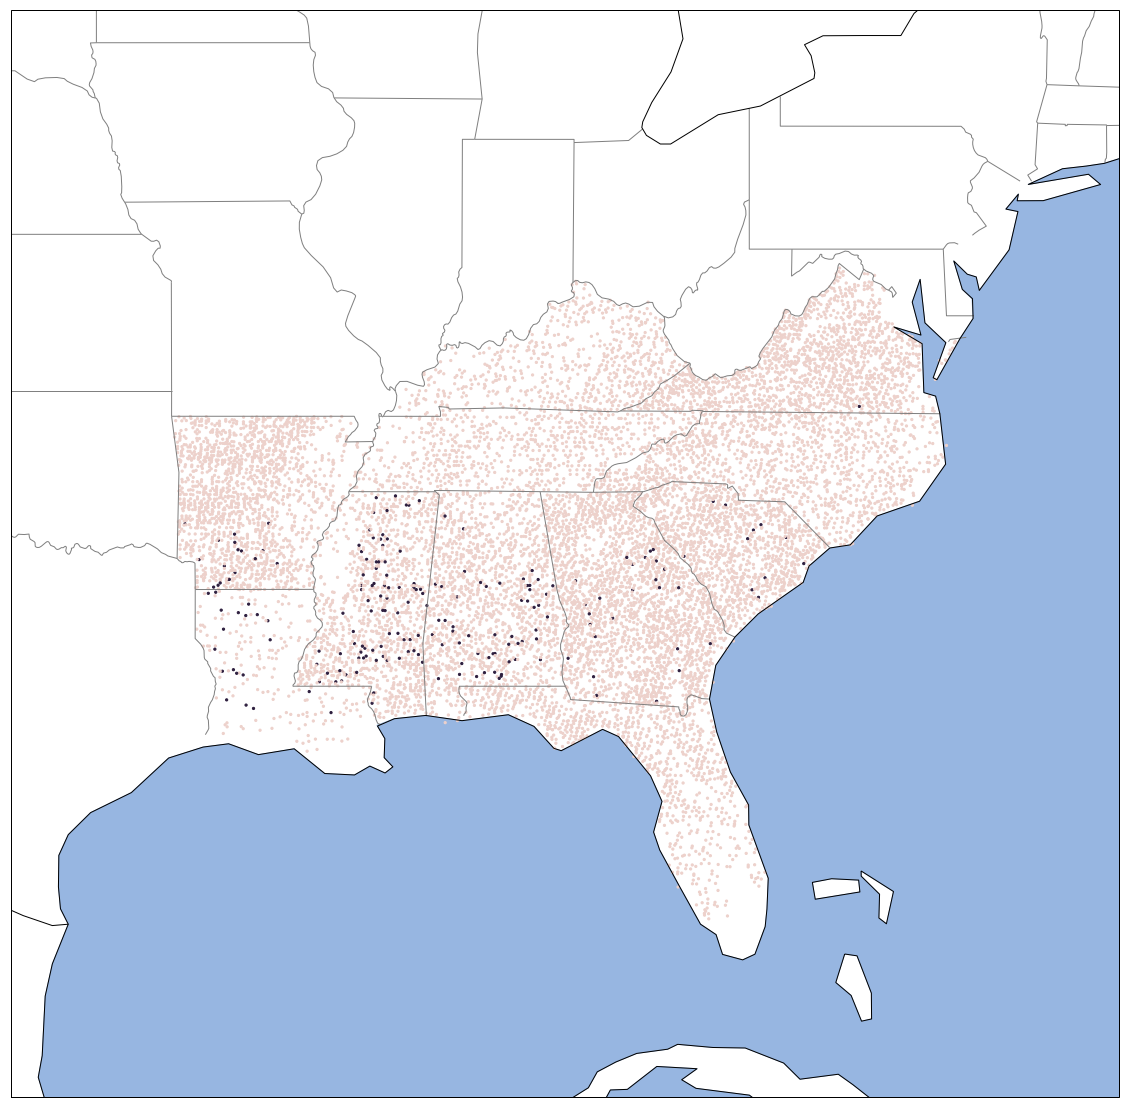

In [370]:
removal_map = heat_scatter_map(df = predicted_final,
                               lon = 'lon',
                               lat = 'lat',
                               color = 'predict_bin')

## Artificial Regeneration Model

In [51]:
regen_form = """~ mjr_access + pellet_min + pellet_50 + prts_d +
 + pellet_count + plp_d + poparea + biop_d + stat_fed 
 + C(ecosubs) + C(statecd)"""

f2 = 'art_regen ' + regen_form

In [52]:
y, X = patsy.dmatrices(f2, remv_mod_df, return_type='dataframe')

In [53]:
regen_mod = Logit(y,X)

In [54]:
regen_out = regen_mod.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3810101705456398
            Iterations: 209
            Function evaluations: 209
            Gradient evaluations: 209


In [55]:
print(regen_out.summary())

                           Logit Regression Results                           
Dep. Variable:              art_regen   No. Observations:                36877
Model:                          Logit   Df Residuals:                    36849
Method:                           MLE   Df Model:                           27
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:                  0.1548
Time:                        15:00:33   Log-Likelihood:                -14051.
converged:                       True   LL-Null:                       -16625.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.8419      0.153    -25.145      0.000      -4.141      -3.542
C(ecosubs)[T.M223]    -0.0222      0.392     -0.056      0.955      -0.791       0.747
C(ecosubs)[T.M231]  

## Fire-Weather Model

In [56]:
fire_form = """~ remv_binary + remv_binary_lag + L_live_volcfgrs_lag + pdsi + mjr_access + pellet_min + pellet_50
 + pellet_count + plp_d + poparea + biop_d + L_H + S_H + ins_dis + stat_fed + prts_d
 + C(ecosubs) + C(invyrtemp) + C(statecd) + art_regen"""

f3 = 'fire_wth' + fire_form

In [57]:
y, X = patsy.dmatrices(f3, remv_mod_df, return_type='dataframe')

In [58]:
remv_out_mod = Logit(y,X)

In [59]:
remv_out = remv_out_mod.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.23453274976926142
            Iterations: 301
            Function evaluations: 303
            Gradient evaluations: 301


In [60]:
print(remv_out.summary())

                           Logit Regression Results                           
Dep. Variable:               fire_wth   No. Observations:                36877
Model:                          Logit   Df Residuals:                    36829
Method:                           MLE   Df Model:                           47
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:                  0.1169
Time:                        15:00:35   Log-Likelihood:                -8648.9
converged:                       True   LL-Null:                       -9793.9
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.7956      0.264    -14.386      0.000      -4.313      -3.278
C(ecosubs)[T.M223]         0.8387      0.184      4.563      0.000       0.478       1.199
C(ec

## Generalized linear mixed effects binomial models (*work in progress*)
### see:

#### https://www.statsmodels.org/dev/generated/statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.html

#### https://www.statsmodels.org/stable/generated/statsmodels.genmod.bayes_mixed_glm.BinomialBayesMixedGLM.html

#### https://www.statsmodels.org/dev/generated/statsmodels.genmod.bayes_mixed_glm.BayesMixedGLMResults.html

In [ ]:
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [ ]:
# adding random effect

remv_form = """~ C(ecosubs) + C(invyrtemp) + remv_binary_lag + L_live_volcfgrs_lag + pdsi + mjr_access + pellet_min + pellet_50
 + pellet_count + plp_d + poparea + biop_d + L_H + S_H + fire_wth + ins_dis + stat_fed + prts_d + art_regen"""

f1 = 'remv_binary ' + remv_form

In [ ]:
# adding random effect for statecd

random = {"a": """0 + C(statecd)"""}

In [ ]:
rand_logit = BinomialBayesMixedGLM.from_formula(f1,random,remv_mod_df)

In [ ]:
out = rand_logit.fit_map()

In [ ]:
print(out.summary())